# Сопоставление признаков и гомография для поиска объектов

## Цель работы:

Реализовать сопоставление изображений с помощью алгоритма RANSAC

## Ход работы

В компьютерном зрении **гомография плоскости** определяется как отображение проекции одной плоскости на другую. Например, отображение точек двумерной плоскости на формирователе изображения камеры является примером плоской гомографии.

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

In [3]:
MIN_MATCH_COUNT = 10

In [29]:
img1 = cv.imread('images/book.jpg') # queryImage
img2 = cv.imread('images/book_in_scene.jpg') # trainImage

In [35]:
# img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
# img2_gray = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

**Масштабно-инвариантная трансформация признаков** (англ. scale-invariant feature transform, **SIFT**) является алгоритмом выявления признаков в компьютерном зрении для выявления и описания локальных признаков в изображениях.

Сначала в SIFT извлекаются ключевые точки объектов из набора контрольных изображений и запоминаются в базе данных. Объект распознаётся в новом изображении путём сравнивания каждого признака из нового изображения с признаками из базы данных и нахождения признаков-кандидатов на основе евклидова расстояния между векторами признаков. 

Запуск детектора SIFT (Scale-Invariant Feature Transform)

In [36]:
sift = cv.SIFT_create()

Поиск ключевых точек и дескрипторов с помощью SIFT

In [39]:
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

**FLANN** используется для фильтрации совпадений на двух изображениях на соотношение расстояний, чтобы попытаться исключить ложные совпадения (Lowe ratio). Вычисляется отношение расстояний между двумя ближайшими соседями рассматриваемой ключевой точки, и она считается хорошим совпадением, если это значение ниже порогового. Действительно, это отношение позволяет различать неоднозначные совпадения (отношение расстояний между двумя ближайшими соседями близко к единице) и хорошо различимые совпадения. 

In [40]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

In [41]:
flann = cv.FlannBasedMatcher(index_params, search_params)

In [42]:
matches = flann.knnMatch(des1,des2,k=2)

Сохраняем все хорошие совпадения в соответствии с Lowe's ratio.

In [43]:
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

Теперь мы задаем условие, что для нахождения объекта должно быть не менее 10 совпадений (определяемых MIN_MATCH_COUNT). В противном случае просто выводим сообщение о том, что совпадений недостаточно.

Если найдено достаточно совпадений, мы извлекаем местоположения совпавших ключевых точек на обоих изображениях. Они передаются для поиска трансформации перспективы. Получив матрицу преобразования 3x3, мы используем ее для преобразования углов queryImage в соответствующие точки на trainImage. Затем выводим его.

In [44]:
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w,d = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print(f'Not enough matches are found - {len(good)}/{MIN_MATCH_COUNT}')
    matchesMask = None

Наконец, мы рисуем наши inliers (в случае успешного нахождения объекта) или совпадающие ключевые точки (в случае неудачи).

In [45]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

In [50]:
img3 = cv.drawMatches(cv.cvtColor(img1, cv.COLOR_BGR2RGB),
                      kp1,
                      cv.cvtColor(img2, cv.COLOR_BGR2RGB),
                      kp2,
                      good,
                      None,
                      **draw_params)

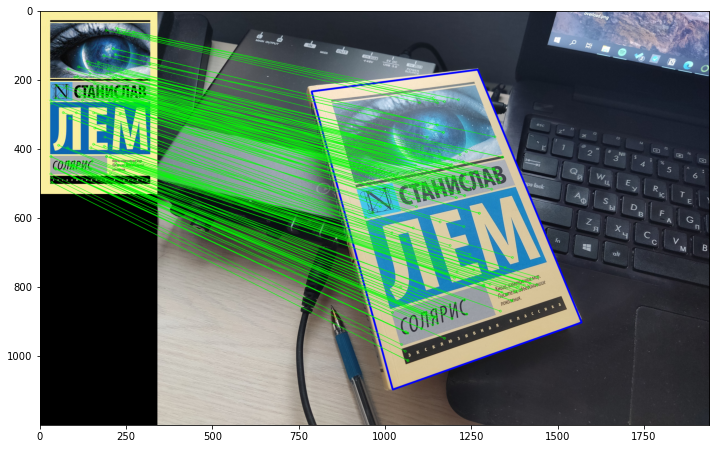

In [52]:
plt.figure(figsize = (12,12))
plt.imshow(img3, 'gray')
plt.show()

## Выводы

Был изучен алгоритм RANSAC для сопоставления двух изображений и сделана его реализация на языке Python с использованием библиотеки OpenCV.